In [2]:
## Import necessary libraries 
from skimage.util import img_as_float
from skimage import io, color
from skimage import draw
import matplotlib.pyplot as plt
import argparse, time
import math, copy
import numpy as np
import scipy.io
import cv2
from PIL import Image, ImageDraw, ImageOps
from google.colab.patches import cv2_imshow
from timeit import default_timer as timer
from scipy.stats import multivariate_normal

In [3]:
def show_image(img, scale=1.0):
    plt.figure(figsize=(10, 10))
    plt.imshow(img, interpolation='bilinear')
    plt.gray() 
    plt.axis('off')
    plt.show()



In [4]:
# Download Data
!gdown 1jbg2VMZ9yAJMHQNRCTgqZM1PyQRtcPyV
!unzip "/content/Part1_SLIC.zip" -d "/content/"

Downloading...
From: https://drive.google.com/uc?id=1jbg2VMZ9yAJMHQNRCTgqZM1PyQRtcPyV
To: /content/Part1_SLIC.zip
100% 6.19M/6.19M [00:00<00:00, 22.8MB/s]
Archive:  /content/Part1_SLIC.zip
   creating: /content/Part1_SLIC/
  inflating: /content/Part1_SLIC/.DS_Store  
  inflating: /content/__MACOSX/Part1_SLIC/._.DS_Store  
   creating: /content/Part1_SLIC/sample_data/
   creating: /content/Part1_SLIC/BSD_data/
  inflating: /content/Part1_SLIC/sample_data/.DS_Store  
  inflating: /content/__MACOSX/Part1_SLIC/sample_data/._.DS_Store  
   creating: /content/Part1_SLIC/sample_data/images/
  inflating: /content/__MACOSX/Part1_SLIC/sample_data/._images  
   creating: /content/Part1_SLIC/sample_data/groundTruth/
  inflating: /content/__MACOSX/Part1_SLIC/sample_data/._groundTruth  
  inflating: /content/Part1_SLIC/BSD_data/.DS_Store  
  inflating: /content/__MACOSX/Part1_SLIC/BSD_data/._.DS_Store  
   creating: /content/Part1_SLIC/BSD_data/images/
   creating: /content/Part1_SLIC/BSD_data/groun

In [5]:
# A class to initialize the super pixels, of the form - [l,a,b,h,w].
class SuperPixel(object):

    def __init__(self, l=0, a=0, b=0, h=0, w=0):
        self.update(l, a, b, h, w)
        self.pixels = []

    def update(self, l, a, b, h, w):
        self.l = l
        self.a = a
        self.b = b
        self.h = h
        self.w = w
        
# Function which returns an object of class SuperPixel
def make_SuperPixel(h, w,img):
    return SuperPixel(img[h,w][0],img[h,w][1],img[h,w][2], h, w)

def display_clusters(img, clusters):
    image = np.copy(img)
    for c in clusters:
        for p in c.pixels:
            image[p[0],p[1]][0] = c.l
            image[p[0],p[1]][1] = c.a
            image[p[0],p[1]][2] = c.b
        image[c.h, c.w][0] = 0
        image[c.h, c.w][1] = 0
        image[c.h, c.w][2] = 0
    rgb_arr = color.lab2rgb(image) 
    show_image(rgb_arr)


In [6]:
# Functions for Simple Linear Iterative Clustering (SLIC)

def initialize_cluster_centers(S, image, img_h, img_w, clusters):
    for h in range(S, img_h, S):
      for w in range(S, img_w, S):
        clusters.append(make_SuperPixel(h, w, image))
    return clusters

def grad_cal(x, y,image,img_w,img_h):
  # Calculates the gradient at a point
    if x + 1 >= img_h:
        x = img_h - 2
    if y + 1 >= img_w:
        y = img_w - 2
    grad = image[x + 1, y + 1][0] - image[x, y][0] + image[x + 1, y + 1][1] - image[x, y][1] + image[x + 1, y + 1][2] - image[x, y][2]
    # print('Grad worked')
    # print('=====')
    return grad

def relocate_cluster_center_at_lowgrad(clusters, image):
   
    for i in range(len(clusters)):
      #gradient of cluster center
      center_grad = grad_cal(clusters[i].h, clusters[i].w,image,img_w,img_h)
      # 3x3 window
      for j in range(-1, 2):
        for k in range(-1, 2):
          x= clusters[i].h + j
          y= clusters[i].w + k
          # gradient of all pixels in 3x3 window
          new_grad = grad_cal(x, y, image, img_w, img_h)
          # update to lowest gradient
          if new_grad < center_grad:
            clusters[i].update(image[x,y][0], image[x,y][1],image[x,y][2], x, y)
    return clusters

def assign_cluster(clusters, S, image, img_h, img_w, cluster_tag, dis):
 
    # To Do: Compare each pixel to cluster center within 2S pixel distance and assign to nearest cluster using the "distance metric"
    # (involving both color and spatial dimensions of pixel and cluster, 
    
    m=20
    for i in range(len(clusters)):
      # for pixels within the 2S range
      for x in range(clusters[i].h - (2 * S), clusters[i].h + (2 * S)):
        if x < 0 or x >= img_h:
          continue
        for y in range(clusters[i].w - (2 * S), clusters[i].w + (2 * S)):
          if y < 0 or y >= img_w: 
            continue
          # calculate D= Dlab + Dxy
          D_lab = np.sqrt(np.square(image[x,y,0] - clusters[i].l) + 
                          np.square(image[x,y,1] - clusters[i].a) + 
                          np.square(image[x,y][2] - clusters[i].b))
          D_xy = np.sqrt(np.square(x - clusters[i].h) + np.square(y - clusters[i].w))
          
          total_d = np.sqrt(np.square(D_lab / m) + np.square(D_xy /S))
          # update
          if total_d < dis[x,y]:
            if (x,y) in cluster_tag:
              cluster_tag[(x,y)].pixels.remove((x,y))
              cluster_tag[(x,y)] = clusters[i]
              clusters[i].pixels.append((x,y))
            else:
              cluster_tag[(x,y)] = clusters[i]
              clusters[i].pixels.append((x,y))
              
            dis[x,y] = total_d
    

def update_clusters(clusters):
    # To Do: For each cluster, update the cluster center with mean of the pixels assigned (c.pixels)
    for i in range(len(clusters)):
      tmp=clusters[i].pixels
      tmp=np.array(tmp).reshape(-1,2)
      x_mean= round(np.mean(tmp[:, 0]))
      y_mean= round(np.mean(tmp[:, 1]))
      clusters[i].update(image[x_mean, y_mean][0], image[x_mean,y_mean][1], image[x_mean,y_mean][2], x_mean, y_mean) 
      # print(x_mean, y_mean)
      # print('=======')



def compute_res_error(old_clusters, new_clusters):
    error = 0.0
    # error = Compute L1 distance between previous cluster-centres and new cluster centers.
    for i in range(len(clusters)):
      L1= (np.abs(clusters[i].h - old_clusters[i].h)) + (np.abs(clusters[i].w - old_clusters[i].w))
      error = error + L1
    
    return error

def slic_algorithm(S, image, img_h, img_w,clusters, tag, dis):

    # Initialize cluster centers on pixel grid in steps S
    clusters = initialize_cluster_centers(S, image, img_h, img_w, clusters)

    # Move centers to position in 3x3 window with smallest gradient.
    relocate_cluster_center_at_lowgrad(clusters, image)

    
    res_err = 10000.0 # init residual_error with a very large value (choose as per your understanding.)
    threshold = 5# tune this
    count=[]
    start = timer()
    while(res_err >= threshold):
      split_1=timer()
      assign_cluster(clusters, S, image, img_h, img_w, tag, dis)
      old_clusters = copy.deepcopy(clusters)
      update_clusters(clusters)
      res_err = compute_res_error(old_clusters, clusters)
      # print('Initial error:', res_err)
      split_2=timer()
      count.append(split_2-split_1)     
      
      # print('Iteration:', count)
      # print('ERROR:',res_err)
      # print('loop time:',time )
      # display_clusters(image, clusters)
      # print('====')
      if res_err<threshold :
        end = timer()
        time= end-start
        # print('Final error:', res_err)
        print('Average runtime:', np.mean(count))
        break
      
     
    return clusters    

working on K= 64
Average runtime: 39.1958930789


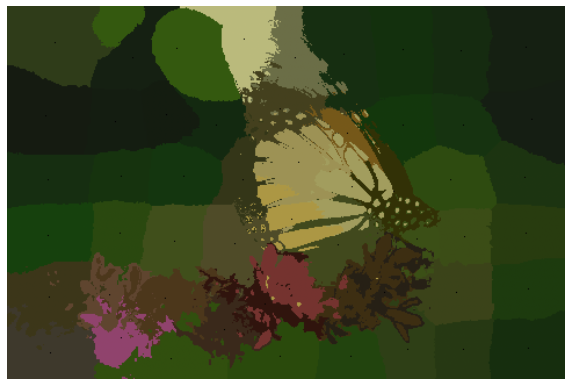

working on K= 256
Average runtime: 43.830081387555566


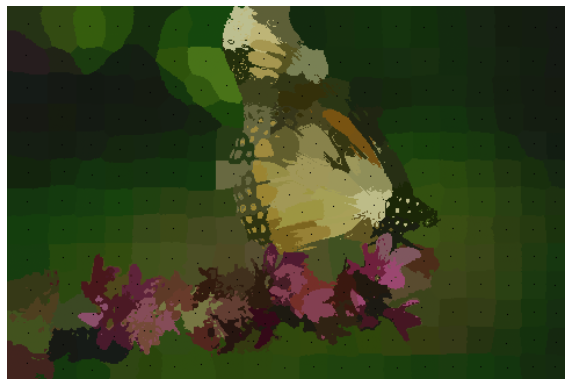

working on K= 1024
Average runtime: 45.63653071957143


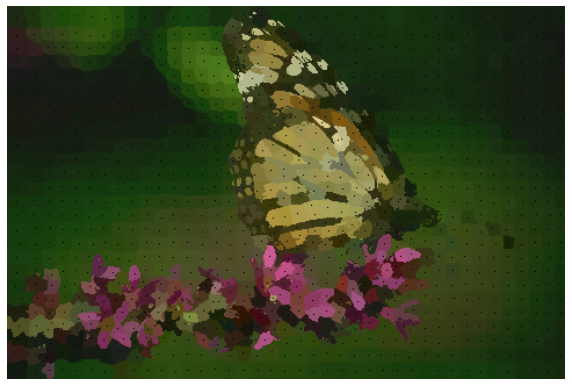

In [7]:
# Main Block:

img_path = "/content/Part1_SLIC/BSD_data/images/35049.jpg"

# Load image and convert it from an unsigned 8-bit integer to a floating point data type.
image = img_as_float(io.imread(img_path))

# convert RGB to LAB
image = color.rgb2lab(image)
img_h = image.shape[0] #  Height
img_w = image.shape[1] #  Width

# k: Number of clusters/superpixels.
final_clus=[]
k = [64, 256, 1024]
for i in k:
  print('working on K=',i)
  N = img_h * img_w  # Total pixels in the image
  S = int(math.sqrt(N /i)) # Average size of each superpixel

  clusters = []
  cluster_tag = {} # cluster_tag should contain cluster-assignment for pixel h,w. For example, cluster_tag[(h, w)] = c
  dis = np.full((img_h, img_w), np.inf) # Distance bwteen pixels and cluster is initialized as infinity at the beginning.
  try:
    clusters = slic_algorithm(S, image, img_h, img_w, clusters, cluster_tag, dis)
    display_clusters(image, clusters)
  except:
    print('issues with Image', 'K=',i)
  print('==========')
